## Using ellc to generate light curves of tidally deformed close-in planets based on the second fluid love number.   

In [20]:
import ellc
import numpy as np
import matplotlib.pylab as plt
import batman
import astropy.constants as c
import astropy.units as u
import Planet_tools as pt

In [2]:
print(ellc.__version__)
print("Installed from https://github.com/tundeakins/ellc")

1.8.2
Installed from https://github.com/tundeakins/ellc


Taking example of WASP_103b with values from [Delrez et al. 2018](https://arxiv.org/pdf/1711.02566.pdf)

In [7]:
P = 0.92554517                                     #days
t0 = 0                                             #mid transit time
aR = 3.010                                         #scaled semimajor axis a/R*
Rp = 0.115                                         # planet radius ratio
inc = 88.8                                         # orbital inclination
u1, u2 = 0.5343,0.1299
ldc_1 = [u1,u2]                                    #limb darkening parameters 
Mst = 1.21                                         #stellar mass in unit of solar masses
Mp = 1.51* c.M_jup.to( u.Msun).value               #planet mass in unit of solar masses
qmass = Mp/Mst                                     #ratio of planet to stellar mass

phases=np.linspace(-0.1,0.1,300)                   #transit phases to calculate flux


### Compare batman light curve to that of ellc for a spherical planet

In [8]:
#generate transit light curve using batman

params = batman.TransitParams()
params.t0 = t0                      #time of inferior conjunction
params.per = 1.                     #orbital period
params.rp = Rp                     #planet radius (in units of stellar radii)
params.a = aR                      #semi-major axis (in units of stellar radii)
params.inc = inc                    #orbital inclination (in degrees)
params.ecc = 0                    #eccentricity
params.w = 90.                      #longitude of periastron (in degrees)
params.u = [u1, u2]               #limb darkening coefficients
params.limb_dark = "quadratic"      #limb darkening model


m = batman.TransitModel(params, phases, max_err=0.001)   #initializes model
flux_batman = m.light_curve(params)  #calculates light curve



In [9]:
#for ellc
r_1 = 1/aR    #radius of star in units of the semimajor axes
r_2 = Rp/aR   #radius of the planet in units of the semimajor axis

ellc_sphere = ellc.lc(phases, t_zero=t0, radius_1=r_1, radius_2=r_2, incl=inc, sbratio=0,
                      ld_1="quad", ldc_1=ldc_1, shape_1='sphere', shape_2='sphere',
                      grid_1="very_fine", grid_2="very_fine") 

ellc_def_hf0 = ellc.lc(phases, t_zero=t0, radius_1=r_1, radius_2=r_2, incl=inc, sbratio=0,
                      ld_1="quad", ldc_1=ldc_1, shape_1='sphere', shape_2='love',
                      grid_1="very_fine", grid_2="very_fine", hf_2=0, q=qmass) 

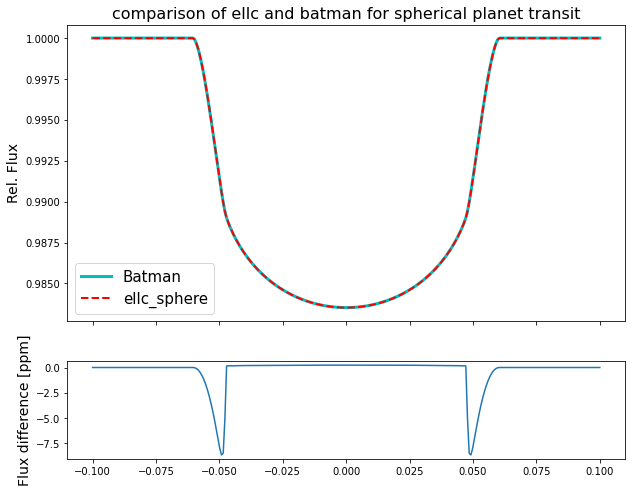

In [10]:
fig, ax = plt.subplots(2,1,figsize=(10,8), gridspec_kw={"height_ratios": (3,1)},sharex=True)
ax[0].plot(phases, flux_batman, "c",lw=3,label="Batman")
ax[0].plot(phases, ellc_sphere, "r--",lw=2,label="ellc_sphere")
ax[0].set_ylabel("Rel. Flux",fontsize=14)
ax[0].set_title("comparison of ellc and batman for spherical planet transit",fontsize=16)
ax[0].legend(fontsize=15)

ax[1].plot(phases, 1e6*(ellc_sphere-flux_batman))
#ax[1].plot(phases, 1e6*(ellc_def_hf0-flux_batman))

ax[1].set_ylabel("Flux difference [ppm]",fontsize=14);



Light curve from both tools are in agreement within 10 ppm

### Tidally deformed planets

Now to compare deformation using the love number approach following [Correia 2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...570L...5C/abstract) and [Akinsanmi et al 2019](https://www.aanda.org/articles/aa/pdf/2019/01/aa34215-18.pdf)

The second fluid love number is given by $h_f$ and ranges from (0, 2.5) with $h_f=0$ being equivalent to a spherical planet model

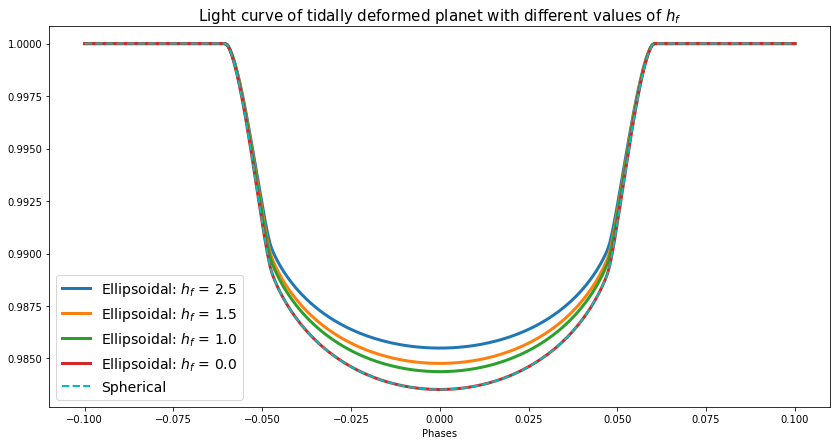

In [11]:
#set shape of the planet shape_2 = "love" and use the following values for hf:
hf_values=[2.5,1.5,1, 0]

plt.figure(figsize=(14,7))
plt.title("Light curve of tidally deformed planet with different values of $h_f$", fontsize=15)

for h_f in hf_values:
    ellc_flux = ellc.lc(phases,t_zero=t0, radius_1=r_1,radius_2=r_2,incl=inc,sbratio=0,
                      ld_1="quad",ldc_1=ldc_1,shape_1='sphere',shape_2='love',
                      q=qmass, hf_2= h_f, grid_1="fine", grid_2="fine") 
    plt.plot(phases, ellc_flux, label = "Ellipsoidal: $h_f$ = {:.1f}".format(h_f), lw=3)
    

#overplot spherical planet light curve    
plt.plot(phases, ellc_sphere, "c--",label="Spherical", lw=2)
plt.legend(fontsize=14)
plt.xlabel("Phases");

Notice that  the  light-curve  of  the  ellipsoidal model  changes  noticeably  for  different  values  of $h_f$ and  also compared to the spherical case. This is because the ellipsoidal planet projects only a small cross-section of its shape during the transit thereby leading to a lower transit depth when compared to the spherical planet. A higher $h_f$ for the same planet causes more deformation, which leads to even smaller projected cross-sectional  area and thus a shallower tansit depth.

The case  where $h_f$ = 0 (although not physical) implies no deformation to the planet so that the ellipsoidal planet model is equivalent to that of a spherical planet (red curve and dashed cyan curve)

### Spherical model fit of simulated transit of deformed WASP-103 (assuming it is oblate and with $h_f=1.5$)

In [12]:
from Planet_tools.convert_param import inclination, impact_parameter, convert_LD_coeffs

def model(params,t,pl_shape="sphere",data=None):
    #params[a,rp,b,t0,q1,q2]
    r_1 = 1./params[0]                          #Rst/a
    r_2 = params[1]/params[0]                   # Rp/a
    incl = inclination(params[2],params[0])     #inclination 
    #u1,u2= params[4],params[5]    
    ldc_1 = [0.29, 0.34]#[u1,u2]
    ellc_flux = ellc.lc(t, t_zero=t0, radius_1=r_1,radius_2=r_2,incl=incl,sbratio=0,ld_1="quad",
                    ldc_1=ldc_1,shape_1='sphere',shape_2=pl_shape, grid_1='fine',
                        grid_2='fine',q=qmass,hf_2=1.5)
    if data is None:
        return ellc_flux
    return np.sum((data - ellc_flux)**2)  #  0.5 * np.sum(((data - ellc_flux))/error) ** 2)

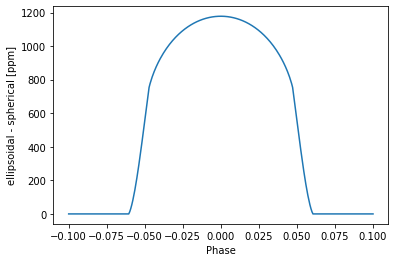

In [13]:
#simulate deformed wasp_103
phase=np.linspace(-0.0863, 0.0863, 230)
b=impact_parameter(inc,aR)
params = [aR, Rp, b]#,  q1,q2]

flux_def = model(params,phases,"love")     #simulate deformed
flux_spr = model(params,phases,"sphere")   #use same parameters to simulate spherical
plt.plot(phases,1e6*(flux_def-flux_spr))
plt.ylabel("ellipsoidal - spherical [ppm]")
plt.xlabel("Phase");

As noted previously the ellipsoidal planet has a shallower transit than spherical planet with same parameters. Therefore, if a spherical planet model is used to fit an ellipsoidal planet, the derived spherical radius will need to be smaller than the volumetric radius, $(abc)^{1/3}$, of the ellipsoidal planet in order to match the transit depth.

### Fit deformed planet light curve with spherical model

In [16]:
#fit spherical planet transit to the deformed planet flux(flux_def)
from scipy.optimize import minimize, least_squares, differential_evolution

#result = minimize(model, [aR,Rp,b], args=(phases, "sphere", flux_def), method="trust-constr")
result = differential_evolution( model, args=(phases, "sphere", flux_def), 
                                bounds=((2.5,3.5),(0.08,0.15),(0.,0.5)),
                                maxiter=500,popsize=5,polish=True)
print(result.x)

[2.99535174 0.11077648 0.10900714]


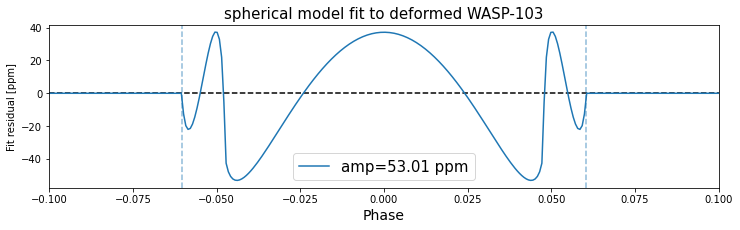

In [31]:
spr_fit = model(result.x,phases,"sphere")
plt.figure(figsize=(12,3))
plt.title("spherical model fit to deformed WASP-103",fontsize=15)
plt.axhline(c="k",ls="dashed")

plt.plot(phases, 1e6*(flux_def-spr_fit), label="amp={:.2f} ppm".format(np.max(np.abs(1e6*(flux_def-spr_fit)))) )
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(fontsize=15)
plt.xlabel("Phase", fontsize=14)
plt.ylabel("Fit residual [ppm]");
plt.axvline(-W/2, ls="dashed", alpha=0.5)
plt.axvline(W/2, ls="dashed", alpha=0.5)

### the projected area
of the ellipsoid during transit compared to the constant spherical planet area.

In [18]:
area_sphere = np.pi * result.x[1]**2
plot_phases = np.linspace(-0.32,0.32,360)
ellps_area, _ = ellc.projected_ellipse_area(plot_phases, Rp, aR, 1.5, qmass, inc)


In [26]:
W = pt.calculate_param.transit_duration(P,Rp,aR,inc=inc)/(P*24)

(-0.32, 0.32)

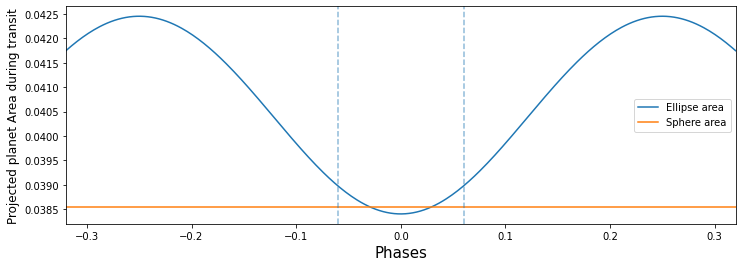

In [46]:

plt.figure(figsize=(12,4))
plt.plot(plot_phases,ellps_area,label="Ellipse area")
plt.plot(plot_phases,area_sphere*np.ones_like(plot_phases),label="Sphere area")
plt.ylabel("Projected planet Area during transit", fontsize=12)
plt.xlabel("Phases", fontsize=15)
plt.legend()
plt.axvline(-W/2, ls="dashed", alpha=0.5)
plt.axvline(W/2, ls="dashed", alpha=0.5)
plt.xlim([min(plot_phases),max(plot_phases)])

#### Normalize by the spherical planet area and show only transit phases

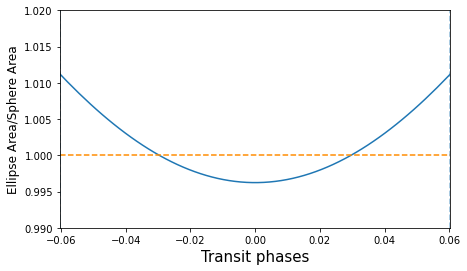

In [54]:
plt.figure(figsize=(7,4))

plt.plot(plot_phases,(ellps_area/area_sphere),label="Ellipse area")
plt.ylabel("Ellipse Area/Sphere Area", fontsize=12)

plt.axhline(1, c = "darkorange", ls="dashed")
plt.axvline(-W/2, ls="dashed", alpha=0.5)
plt.axvline(W/2, ls="dashed", alpha=0.5)
plt.xlim([-W/2,W/2])
plt.ylim([0.99,1.02])
plt.xlabel("Transit phases", fontsize=15);


## Estimating $h_f$ for JWST observation

In [17]:
#ellc model for deformed (ellipsoidal) planet
def model(params,t):
    #params[aR,rp,b,hf,q1,q2,t0,log_qmass]
    
    r_1 = 1./params[0]                                   #Rst/a
    r_2 = params[1]/params[0]                            # Rp/a
    incl = np.rad2deg(np.arccos(params[2]/params[0]))    #inclination
    hf = params[3]                                       #love number
    ld_1 = 'quad'
    u1,u2= convert_LD_coeffs(params[4],params[5],"q2u",False)        #convert kippinglD to quadratic
    ldc_1 = [u1, u2]
    qmass = 0.001191270                              # Mp/Mst
    #print(qmass)
    
    elps_pl=ellc.lc(t, t_zero=0, radius_1=r_1, radius_2=r_2, incl=incl, sbratio=0, ld_1=ld_1, ldc_1=ldc_1,
                    shape_1='sphere', shape_2='love', grid_1='default', grid_2='default',
                    q=qmass,hf_2=hf)
    return elps_pl

In [18]:
phase=np.linspace(-0.0863, 0.0863, 230)  #1min cadence

In [20]:
from uncertainties import ufloat
u1, u2 =  ufloat(0.226, 0.005), ufloat(0.155,0.007)      #quad ld for jwst from exoctk
q1, q2 = convert_LD_coeffs(u1,u2, "u2q")
b = impact_parameter(inc, aR)
q1,q2, b

(0.145161+/-0.006554971853486482,
 0.29658792650918636+/-0.00606785734989163,
 0.06303668384890472)

In [21]:
initial = [aR, Rp, b, 1.5, q1.n, q2.n]
y = model(initial, phase)
#np.random.seed(35)
yerr = np.random.normal(0,100e-6,len(phase))
y += yerr

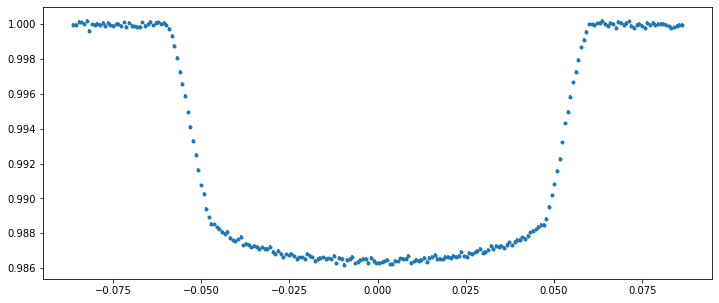

In [22]:
%matplotlib inline
plt.figure(figsize=(12,5))
plt.errorbar(phase, y, yerr=np.ones_like(y)*100e-6, fmt="." );


In [23]:
from scipy.stats import norm, uniform,loguniform
from multiprocessing import Pool

a_  = norm(aR, 0.015)
rp_ = uniform(0.08, 0.12) #norm(rp_sphr.n, 10*rp_sphr.s) #
b_  = uniform(0, 0.4)
hf_ = uniform(0, 2.5)
q1_ = norm(q1.n, 2*q1.s)
q2_ = norm(q2.n, 2*q2.s)
#ln_sig_ = uniform(-20, 19)

priors = [a_,rp_,b_,hf_,q1_,q2_]#,ln_sig_]


In [24]:
  
def lnprior(params):
    lp = 0.0
    aR, rp, b, hf, q1, q2 = params
    if not (0 < q1 < 1 and 0 <= q2 < 1):
        return -np.inf
    for par, pr in zip(params, priors[:len(params)]):
        lp += pr.logpdf(par)
    return lp

def prior_transform(u):
    x = np.array(u)
    
    for i, pr in enumerate(priors):
        x[i] = pr.ppf(u[i])
    return x
        
    

def lnlike(params, t, y, yerr):
    return -0.5 * np.sum(((y - model(params, t))/yerr) ** 2)


def lnprob(params, t, y, yerr):
    lp = lnprior(params)
    return lp + lnlike(params, t, y, yerr) if np.isfinite(lp) else -np.inf


In [25]:
#initializing the walkers
labels=["$a/R_{\\ast}$", "$R_{p}$", "$b$", "$h_{f}$", "$q_{1}$", "$q_{2}$"]#, "ln_$\sigma$"]
ndim, nwalkers = len(labels), 512



#initializing the walkers to random values within the prior prior distributions

pos = []
for i in range(nwalkers):
    P0i = []
    for p in priors:
        P0i.append(p.rvs())
    pos.append(P0i)
pos=np.array(pos)
#start with hf close to zero
pos[:,3]=uniform(0,1.4).rvs(nwalkers)

In [226]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, len(initial), lnprob, args=(phase, y, np.ones_like(y)*100e-6),
                                pool=Pool(4))# moves=emcee.moves.DEMove())
print("Running production")
sampler.run_mcmc(pos, 5000, progress=True);

Running production


100%|██████████| 5000/5000 [1:47:20<00:00,  1.28s/it]


In [26]:
import dynesty
sampler = dynesty.NestedSampler(lnlike,prior_transform, ndim, bound="single", nlive=300,
                                logl_args= (phase, y, np.ones_like(y)*100e-6), pool=Pool(4), queue_size=3)
sampler.run_nested(dlogz=0.01)

/home/tunde/miniconda3/envs/python3_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
5290it [18:19,  1.48s/it, bound: 480 | nc: 507 | ncall: 272664 | eff(%):  1.940 | loglstar:   -inf < -123.767 <    inf | logz: -136.556 +/-  0.270 | dlogz:  0.010 >  0.010]   


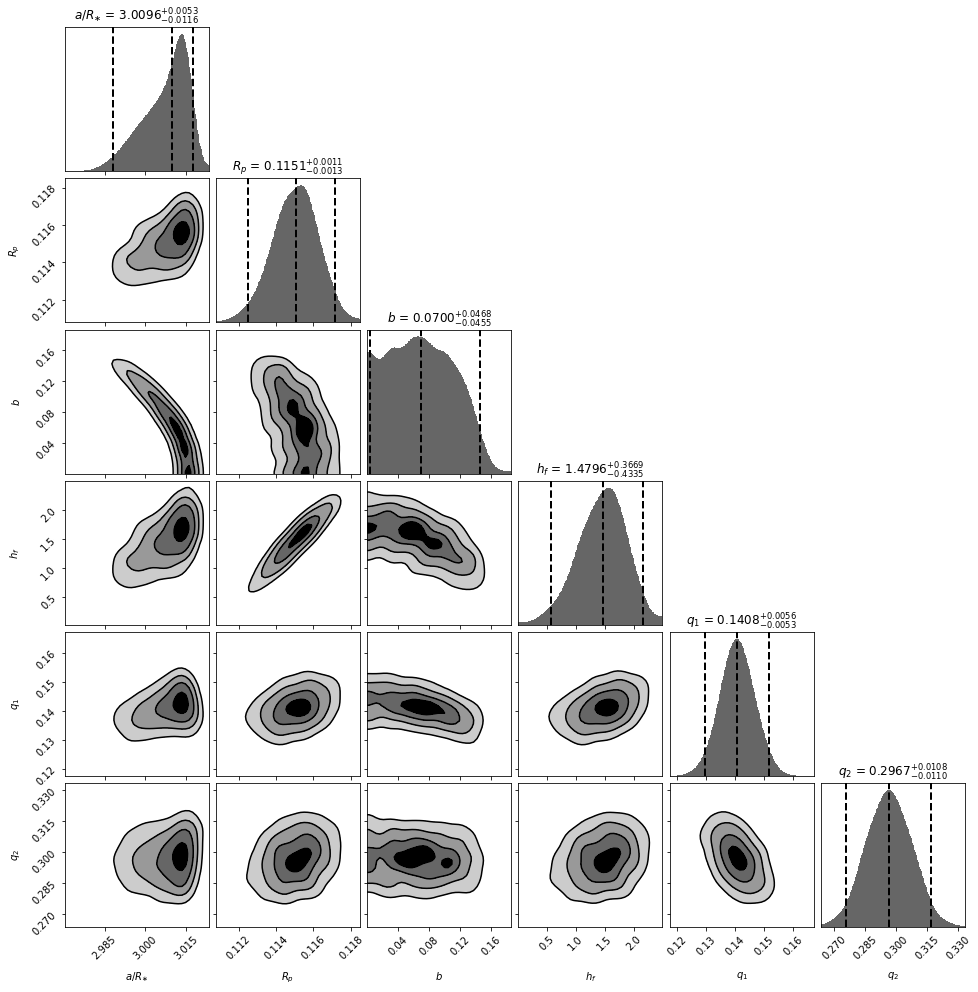

In [28]:
import dynesty.plotting as dyplot
res = sampler.results


dyplot.cornerplot(res, labels=labels, smooth=0.05, show_titles=True,title_fmt=".4f" );

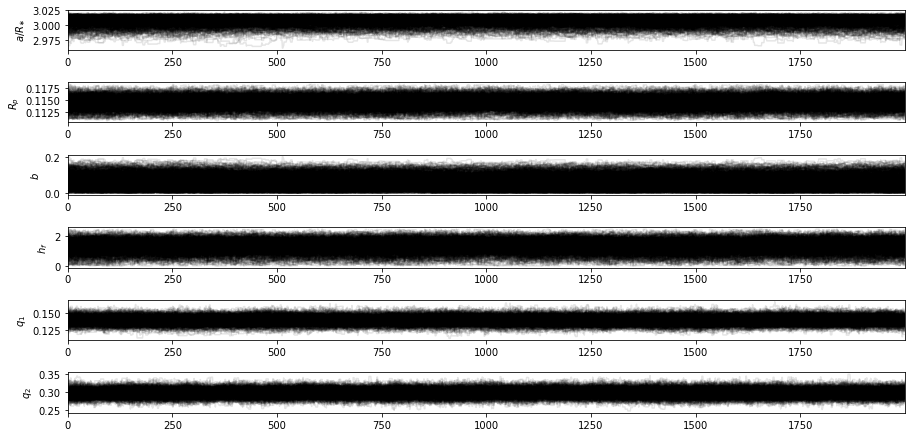

In [242]:
plt.figure(figsize=(15,7))
for j in range(ndim):
    plt.subplot(ndim,1,j+1)
    plt.ylabel(labels[j])
    plt.autoscale(enable=True, axis='x', tight=True)
    for i in range(0,nwalkers-1): plt.plot(sampler.chain[i,3000:, j],"k",alpha=0.1)
    plt.subplots_adjust(hspace=0.8,bottom=0.1, top=0.9)

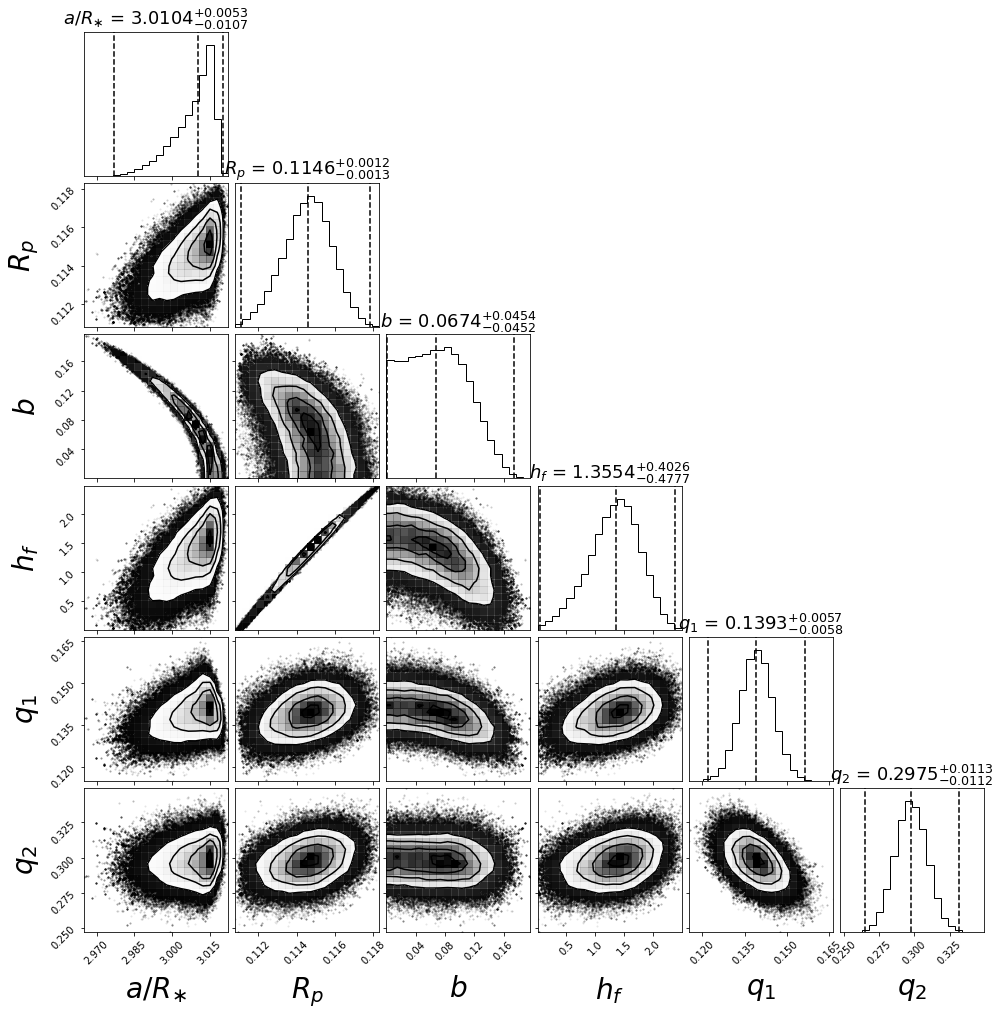

In [240]:
import corner
samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=labels,show_titles=True,
                    title_fmt=".4f",quantiles=[0.0015,0.5,0.9985],title_kwargs={"fontsize": 18},
                    label_kwargs={"fontsize":28})
